## Doyle Reaction Prediction Pt. 2: Performance with Random Features

Fig. 2 from the Doyle paper randomly samples to create a 30% test set. Given that they are randomly sampling from the exhaustive set of all combinations of ligands, substrates, additives, and bases, it's possible that the chemical features aren't necessary to recapitulate Fig. 2.

Hypothesis: 

    Equivalent performance can be achieved without the use of any chemical features.

Design:
    
    We will randomly create "molecular features" of the same length (additives: n=19, aryl halides: n=27, bases: n=10, ligands: n=64) and concatenate these to generate length 120 vectors that closely mimic the reaction inputs that Doyle et al use. We'll test on the equivalent of Fig. 2 to see how they perform. For this experiment, we expect significantly worse generalization, since every random descriptor becomes fully decorrelated with every other random descriptor.

In [1]:
# Import our libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.stats import pearsonr

# Import relevant scikit-learn modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score

# Load RPy2 Libraries for R dataframes
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects

import utils

# set a seed for all the randoms
np.random.seed(42)

In [2]:
# Define path and constants
DATA_DIR = 'data/'
YIELDS_DF = 'yields.csv'  # Used modified analysis.R script, see yields.R file
COLS_INFO = 'col_layout.csv' # generated from their SI, see above
PLATE_INFO = 'plate_layout.csv' # generated from their SI, see above
TRAIN_DF = 'training_scaled.rds' # Scaled training data from github.com/doylelab/rxnpredict
TEST_DF = 'test_scaled.rds'      # Scaled test set data from github.com/doylelab/rxnpredict
INPUTS = 'output_table.csv'      # Unscaled  data from github.com/doylelab/rxnpredict

In [3]:
# Load row and column data
cols = pd.read_csv(DATA_DIR + COLS_INFO)
plates = pd.read_csv(DATA_DIR + PLATE_INFO)

In [4]:
# as in the paper, remove controls and additive 7
cols_no_controls   = cols.drop([15, 31, 47]) # remove controls as in paper
plates_no_controls = plates.drop([0, 4, 8, 12, 19, 23, 27, 31]) # remove additive 7 as in paper

In [5]:
aryl_halide_cats = pd.Categorical(cols_no_controls['Aryl Halide']).categories
base_cats = pd.Categorical(cols_no_controls['Base']).categories
ligand_cats = pd.Categorical(plates_no_controls['Ligand']).categories
additive_cats = pd.Categorical(plates_no_controls['Additive']).categories

In [6]:
# first 19 are additives
# 27 aryl halide descriptors
# 10 base descriptors
# 64 ligand descriptors

# create dictionaries to store random chemical features  
# to each molecule, each molecule gets its own
# unique set of random features of equal length
# as Doyle's featurization protocol

halide_descriptors = {}
HAL_DESC = 27
for aryl_halide in aryl_halide_cats:
    # generate random descriptors
    halide_descriptors[aryl_halide] = np.random.normal(size=HAL_DESC)
    
base_descriptors = {}
BASE_DESC = 10
for base in base_cats:
    # generate random descriptors
    base_descriptors[base] = np.random.normal(size=BASE_DESC)
    
ligand_descriptors = {}
LIG_DESC = 64
for ligand in ligand_cats:
    # generate random descriptors
    ligand_descriptors[ligand] = np.random.normal(size=LIG_DESC)
    
additive_descriptors = {}
ADD_DESC = 19
for additive in additive_cats:
    # generate random descriptors
    additive_descriptors[additive] = np.random.normal(size=ADD_DESC)

In [7]:
# generate the reactions based on the layouts
# from the supporting information
vectors = []
for row_idx, row in enumerate(plates_no_controls.iterrows()):
    ligand = row[1]['Ligand']
    lig_fp = ligand_descriptors[ligand]
    additive = row[1]['Additive']
    add_fp = additive_descriptors[additive]
    cols = []
    for col_idx, col in enumerate(cols_no_controls.iterrows()):
        base = col[1]['Base']
        base_fp = base_descriptors[base]
        aryl_halide = col[1]['Aryl Halide']
        aryl_halide_fp = halide_descriptors[aryl_halide]
        array = np.concatenate([add_fp, aryl_halide_fp, base_fp, lig_fp])
        cols.append(array)
    vectors.append(cols)

In [8]:
vectors = np.array(vectors)
X_set= vectors.reshape(vectors.shape[0] * vectors.shape[1], vectors.shape[2])

In [9]:
X_set.shape # We have 3960 entries of 120  features each

(3960, 120)

In [10]:
# Load yields, remove control reactions
yields = pd.read_csv(DATA_DIR + YIELDS_DF)
yields = np.array(yields['x'])
yields = yields.reshape(3 * 32, 48)
yields = np.delete(yields, [0, 4, 8, 12, 19, 23, 27, 31], axis=0)
yields = np.delete(yields, [15, 31, 47], axis=1)
yields = yields.flatten()
y_set = yields

# it turns out the yield data contains some NaNs
# we set these to zeros
for idx, value in enumerate(y_set):
    if np.isfinite(value) == False:
        print(idx, value)
        y_set[idx] = 0

696 nan
741 nan
796 nan
797 nan
884 nan


In [11]:
# Activate RPy2
pandas2ri.activate()
readRDS = robjects.r['readRDS']

# load R dataframes
train_rds = readRDS(DATA_DIR + TRAIN_DF)
test_rds  = readRDS(DATA_DIR + TEST_DF)

# convert these to pandas dataframes
train_df = pandas2ri.ri2py(train_rds)
test_df  = pandas2ri.ri2py(test_rds)

train_indices = train_df.sort_index().index - 1
test_indices = test_df.sort_index().index - 1

In [12]:
X_train = X_set[train_indices]
y_train = y_set[train_indices]

X_test = X_set[test_indices]
y_test = y_set[test_indices]

In [13]:
models = [LinearRegression(), # use default
          KNeighborsRegressor(n_neighbors=7), # use k = 7
          LinearSVR(),        # mimic R-default values
          MLPRegressor(hidden_layer_sizes=(5), # mimic the paper values
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          MLPRegressor(hidden_layer_sizes=(100),
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          RandomForestRegressor(n_estimators=500, # 500 trees
                                random_state=42)
         ]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden

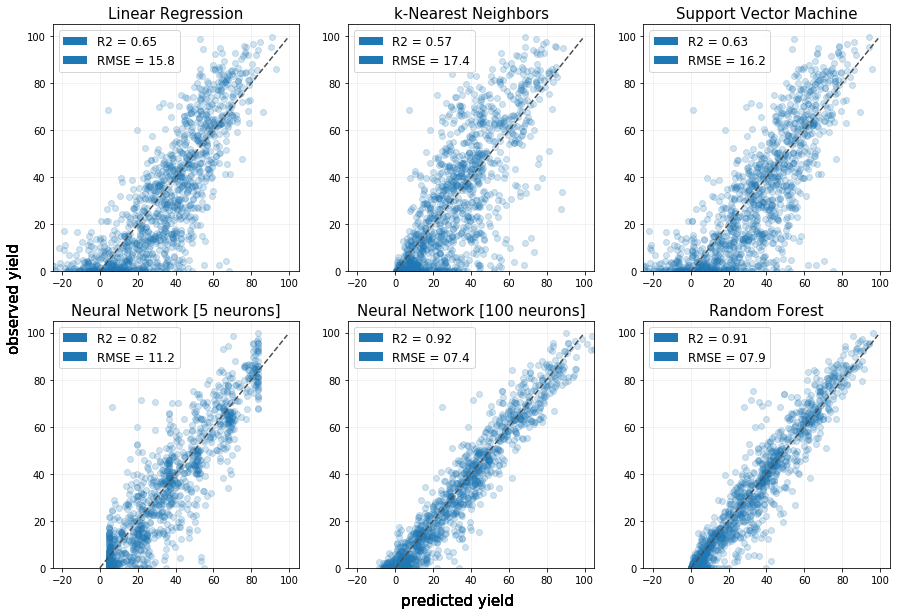

In [14]:
preds, r2_values, rmse_values = utils.fit_models(X_train,
                                                 X_test,
                                                 y_train,
                                                 y_test,
                                                 models)

utils.plot_models(preds,
                  r2_values,
                  rmse_values,
                  y_test,
                  save='plots/random_models.png')

Overall the results are strikingly similar to those with chemical features. 

Conclusion:
   
    With random sampling, the random train/test split are inadequate for distinguishing between models trained on chemical features (last notebook) and models trained on random features.

### Testing Plate Predictions

In [15]:
# Train on plates 1 and 2
X_train_3 = X_set[:2520]
y_train_3 = yields[:2520]

# Test on plate 3
X_test_3 = X_set[2520:]
y_test_3 = yields[2520:]

dataset_3 = [X_train_3, y_train_3, X_test_3, y_test_3]

# Train on plates 1 and 3
X_train_2 = np.concatenate([X_set[:1080], X_set[2520:]])
y_train_2 = np.concatenate([yields[:1080], yields[2520:]])

# Test on plate 2
X_test_2 = X_set[1080:2520]
y_test_2 = yields[1080:2520]

dataset_2 = [X_train_2, y_train_2, X_test_2, y_test_2]

# Train on plates 2 and 3
X_train_1 = X_set[1080:]
y_train_1 = yields[1080:]

# Test on plate 1
X_test_1 = X_set[:1080]
y_test_1 = yields[:1080]

dataset_1 = [X_train_1, y_train_1, X_test_1, y_test_1]

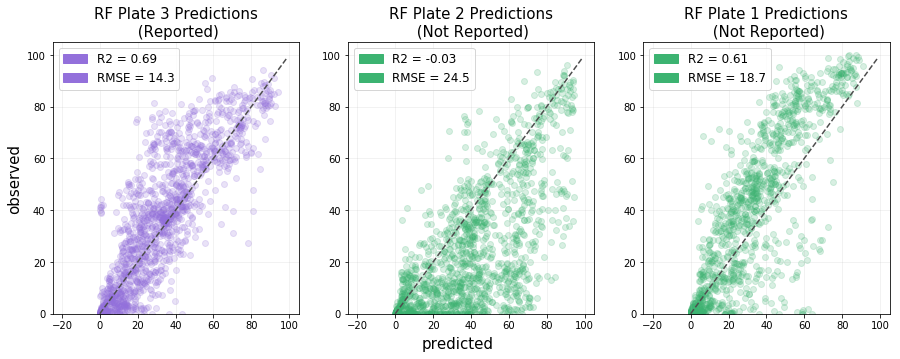

In [16]:
# Define RF models
models = [RandomForestRegressor(n_estimators=500,
                                random_state=42),
          RandomForestRegressor(n_estimators=500,
                                random_state=42),
          RandomForestRegressor(n_estimators=500,
                                random_state=42)]
datasets = [dataset_3, dataset_2, dataset_1]

predictions = []
r2_values = []
rmse_values = []

for i, (data, model) in enumerate(zip(datasets, models)):
    model.fit(data[0], data[1])
    preds = model.predict(data[2])
    r_squared = r2_score(data[3], preds)
    rmse = mean_squared_error(preds,  data[3]) ** 0.5
    
    predictions.append(preds)
    r2_values.append(r_squared)
    rmse_values.append(rmse)
    
titles = ['RF Plate 3 Predictions\n (Reported)',
          'RF Plate 2 Predictions\n (Not Reported)',
          'RF Plate 1 Predictions\n (Not Reported)']
fig = plt.figure(figsize=(15,5))
colors = ['mediumpurple','mediumseagreen','mediumseagreen']

for i, color in enumerate(colors):
    fig.add_subplot(1,3,i+1)
    plt.title(titles[i], fontsize=15)
    plt.grid(alpha=0.2)
    r2_patch = mpatches.Patch(label="R2 = {:04.2f}".format(r2_values[i]),color=color)
    rmse_patch = mpatches.Patch(label="RMSE = {:04.1f}".format(rmse_values[i]), color=color)
    plt.xlim(-25,105)
    plt.ylim(0,105)
    plt.scatter(predictions[i], datasets[i][3], alpha=0.2, c=color)
    plt.legend(handles=[r2_patch, rmse_patch], fontsize=12)
    plt.plot(np.arange(100), np.arange(100), ls="--", c=".3")
fig.text(0.5, 0.04, 'predicted', ha='center', va='center', fontsize=15)
fig.text(0.09, 0.5, 'observed', ha='center', va='center', rotation='vertical', fontsize=15)
plt.show()

These results still track closely with those obtained with chemical features. An important consideration is that this method is entirely dependent on the random numbers, and can vary trial-to-trial based on randomization. To account for this variation, we'll repeat the trial 20 times and give R_squared and RMSE values over all of those trials.

In [17]:
def generate_descriptor_dataset():
    halide_descriptors = {}
    HAL_DESC = 27
    for aryl_halide in aryl_halide_cats:
        # generate random descriptors
        halide_descriptors[aryl_halide] = np.random.normal(size=HAL_DESC)

    base_descriptors = {}
    BASE_DESC = 10
    for base in base_cats:
        # generate random descriptors
        base_descriptors[base] = np.random.normal(size=BASE_DESC)

    ligand_descriptors = {}
    LIG_DESC = 64
    for ligand in ligand_cats:
        # generate random descriptors
        ligand_descriptors[ligand] = np.random.normal(size=LIG_DESC)

    additive_descriptors = {}
    ADD_DESC = 19
    for additive in additive_cats:
        # generate random descriptors
        additive_descriptors[additive] = np.random.normal(size=ADD_DESC)
    
    # generate the reactions based on the layouts
    # from the supporting information
    vectors = []
    for row_idx, row in enumerate(plates_no_controls.iterrows()):
        ligand = row[1]['Ligand']
        lig_fp = ligand_descriptors[ligand]
        additive = row[1]['Additive']
        add_fp = additive_descriptors[additive]
        cols = []
        for col_idx, col in enumerate(cols_no_controls.iterrows()):
            base = col[1]['Base']
            base_fp = base_descriptors[base]
            aryl_halide = col[1]['Aryl Halide']
            aryl_halide_fp = halide_descriptors[aryl_halide]
            array = np.concatenate([add_fp, aryl_halide_fp, base_fp, lig_fp])
            cols.append(array)
        vectors.append(cols)
    vectors = np.array(vectors)
    X_set = vectors.reshape(vectors.shape[0] * vectors.shape[1], vectors.shape[2])
    return X_set
    
def split_by_plate(X_set, y_set):
    # Train on plates 1 and 2
    X_train_3 = X_set[:2520]
    y_train_3 = yields[:2520]

    # Test on plate 3
    X_test_3 = X_set[2520:]
    y_test_3 = yields[2520:]

    dataset_3 = [X_train_3, y_train_3, X_test_3, y_test_3]

    # Train on plates 1 and 3
    X_train_2 = np.concatenate([X_set[:1080], X_set[2520:]])
    y_train_2 = np.concatenate([yields[:1080], yields[2520:]])

    # Test on plate 2
    X_test_2 = X_set[1080:2520]
    y_test_2 = yields[1080:2520]

    dataset_2 = [X_train_2, y_train_2, X_test_2, y_test_2]

    # Train on plates 2 and 3
    X_train_1 = X_set[1080:]
    y_train_1 = yields[1080:]

    # Test on plate 1
    X_test_1 = X_set[:1080]
    y_test_1 = yields[:1080]

    dataset_1 = [X_train_1, y_train_1, X_test_1, y_test_1]
    return [dataset_1, dataset_2, dataset_3]

In [18]:
results = []
for i in range(20):
    X_set = generate_descriptor_dataset()
    datasets = split_by_plate(X_set, y_set)
    # Define RF models
    models = [RandomForestRegressor(n_estimators=500,
                                    random_state=42,
                                    n_jobs=-1),
              RandomForestRegressor(n_estimators=500,
                                    random_state=42,
                                    n_jobs=-1),
              RandomForestRegressor(n_estimators=500,
                                    random_state=42,
                                    n_jobs=-1)]
    predictions = []
    r2_values = []
    rmse_values = []

    for i, (data, model) in enumerate(zip(datasets, models)):
        model.fit(data[0], data[1])
        preds = model.predict(data[2])
        r_squared = r2_score(data[3], preds)
        rmse = mean_squared_error(preds,  data[3]) ** 0.5

        predictions.append(preds)
        r2_values.append(r_squared)
        rmse_values.append(rmse)
    results.append([r2_values, rmse_values])

In [19]:
results_array = np.array(results)

In [20]:
results_array.mean(axis=0)

array([[ 0.47166801,  0.10507851,  0.55142986],
       [21.51001006, 22.75800197, 17.07737435]])

Overall, we see diminished performance with random "barcodes," but still less so than we would have initially anticipated.